In [7]:
import sys
sys.path.append('..')

In [8]:
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm import tqdm
from itertools import product
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from typing import List, Dict
from CommonFunctions import enhance_plot
from Models import SimpleCNN, ModularVGG
from Utils import *
%matplotlib inline

In [9]:
PARAMS = LearningParameters()
PARAMS.dropout = 0
PARAMS.batch_norm = False
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)

def VGG11():
    model_config = dict(
        CONV=dict(
            conv_layers=[[64],
                         [128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    )
    return ModularVGG(input_layer_size=3,
                      num_of_classes=10,
                      image_size=32,
                      config=model_config)
PARAMS

LearningParameters(batch_size=128, cpu_count=12, learning_rate=0.05, momentum=0.9, weight_decay=0.001, epochs=150, device=device(type='cuda'), dropout=0, batch_norm=False)

In [10]:
def l1_l2_regularization(model, lambda_l1, lambda_l2):
    l1_loss = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_loss = sum(torch.sum(param ** 2) for param in model.parameters())
    return lambda_l1 * l1_loss + lambda_l2 * l2_loss

def train_step_with_reg(model, dataloader, criterion, accuracy_function, optimizer, device,
                        lambda_l1=0, lambda_l2=0):
    train_loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        mse_loss = criterion(y_pred, y)
        reg_loss = l1_l2_regularization(model, lambda_l1, lambda_l2)
        # print(mse_loss, reg_loss)
        loss = mse_loss + reg_loss
        accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= (data_len := len(dataloader))
    accuracy /= data_len
    return train_loss, accuracy


def plot_loss(title, epochs, loss_dict, axes_size, file):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*axes_size, layout='constrained', figsize=(6, 8))
        x_axis = range(1, epochs + 1)
        for ax, ((L1, L2), (loss_train, loss_val)) in zip(figure.axes, loss_dict.items()):
            ax.plot(x_axis, loss_train, label='Train')
            ax.plot(x_axis, loss_val, label='Test')
            ax.set(title=f'L1 = {L1:.2f}\nL2 = {L2:.2f}')
            enhance_plot(figure, axes, glow=True, alpha_gradient=0.4)
        figure.suptitle(title)
        figure.savefig(f'./images/{file}.png')

# VGG with L1, L2 and no regularization

In [15]:
data_path = Path('./data')
loss_dict = {}
_, _, train_dataloader, test_dataloader = load_CIFAR10(
    data_path, normalized_transform(), subset=(20000, 4000))

L1, L2 = 5.e-4, 2.e-4
PARAMS.learning_rate = 0.01
PARAMS.batch_size = 128
PARAMS.epochs = 30
PARAMS.momentum = 0.3
L1_list = [0, L1, 0, L1]
L2_list = [0, 0, L2, L2]
model_names = ['vanilla', 'L1 regularization', 'L2 regularization', 'Both Regularizations']

for model_name, L1, L2 in zip(model_names, L1_list, L2_list):
    print(f'{model_name}, L1: {L1}, L2: {L2}')
    model = SimpleCNN()
    model.to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=PARAMS.momentum)
    train_time_start = timer()
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step_with_reg(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device,
            lambda_l1=L1, lambda_l2=L2)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        val_loss.append(test_metrics[0])
    loss_dict[model_name] = (train_loss, val_loss)
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

vanilla, L1: 0, L2: 0


100%|██████████| 30/30 [04:51<00:00,  9.72s/it]


Time: 291.666 seconds
L1 regularization, L1: 5e-05, L2: 0


100%|██████████| 30/30 [04:47<00:00,  9.57s/it]


Time: 287.203 seconds
L2 regularization, L1: 0, L2: 0.0002


100%|██████████| 30/30 [04:44<00:00,  9.47s/it]


Time: 284.172 seconds
Both Regularizations, L1: 5e-05, L2: 0.0002


100%|██████████| 30/30 [04:54<00:00,  9.82s/it]

Time: 294.575 seconds


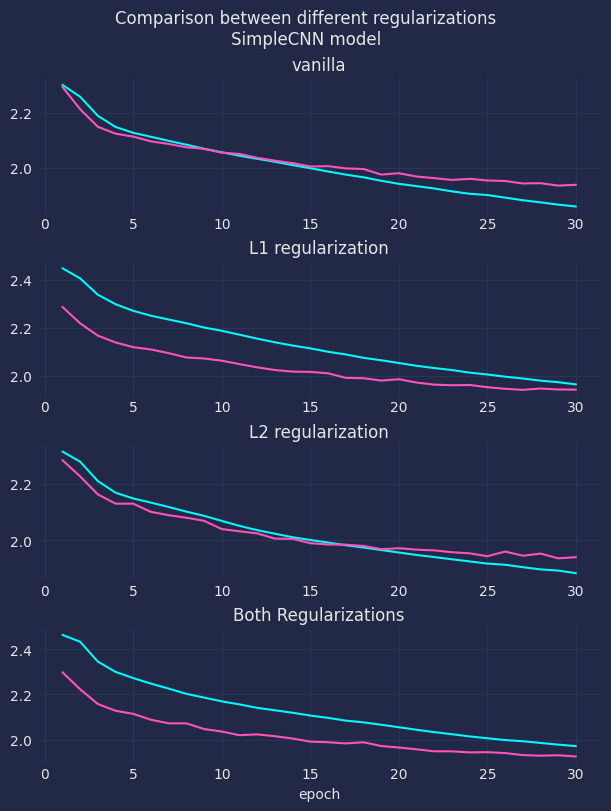

In [17]:
title = 'Comparison between different regularizations\nSimpleCNN model'
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 1, layout='constrained', figsize=(6, 8))
    x_axis = range(1, PARAMS.epochs + 1)
    for ax, (model_type, (train, val)) in zip(figure.axes, loss_dict.items()):
        ax.plot(x_axis, train, label='Train')
        ax.plot(x_axis, val, label='Validation')
        ax.set(title=model_type)
    axes[3].set(xlabel='epoch')
    figure.suptitle(title)